# 데이콘: 이커머스 고객 세분화 분석 아이디어 경진대회
---

- 해당 대회에 대한 간단한 소개와 인사글은 README.md 파일에 작성되어 있습니다.

- 혹시 보고싶으신 분은 [이 텍스트를 클릭해주세요. 깃허브 링크로 연결됩니다](https://github.com/Randy-archive/ecommerce_seg)

---

안녕하세요, 대회에 참여하게 된 랜디 Randy입니다.

기본적으로 주어진 모든 데이터를 활용해 연관성을 찾기 위해 노력했습니다.

만약 실제 프로젝트였다면

연관성이 없다 하여 분석한 내용을 뺄 경우 다른 팀원이 똑같은 분석을 중복해서 작업할 가능성이 있습니다.

따라서 연관성을 찾지 못한 항목도 효율성 측면에서 나름의 의미가 있기 때문에,

빼지 않고 목차에 넣어두었습니다.

목차는 아래와 같습니다.

# [Index]
---

1. 데이터 살펴보기

2. 온라인 마케팅 비용의 효율성

3. 간단한 고객 분석

    1. 가입 기간과 매출액의 관계

    2. 각 카테고리의 충성 고객

        1. 지역별

        2. 성별

4. 세금, 그리고 매출

5. 할인율과 매출의 주기성

6. 할인율에 따른 리텐션 Cohort 분석

7. 제품 분류

    a. 월별 Best, Worst 제품

    b. 1년 합산 Best, Worst 제품

8. RFM 분석

9. 결론 요약


In [199]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


In [200]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

# [1. 데이터 살펴보기]

어떤 데이터가 어떤 형식으로 존재하는지 한번 살펴보도록 하겠습니다.

In [179]:
customer_data = pd.read_csv('Customer_info.csv')
discount_data = pd.read_csv('Discount_info.csv')
marketing_data = pd.read_csv('Marketing_info.csv')
onlinesales_data = pd.read_csv('Onlinesales_info.csv')
tax_data = pd.read_csv('Tax_info.csv')

customer = customer_data.copy()
discount = discount_data.copy()
marketing = marketing_data.copy()
onlinesales = onlinesales_data.copy()
tax = tax_data.copy()

print(customer.shape)
customer.head()
# 고객 ID, 성별, 고객지역, 가입기간(단위: 월)

(1468, 4)


,고객ID,성별,고객지역,가입기간
0,USER_1358,남,Chicago,12
1,USER_0190,남,California,43
2,USER_0066,남,Chicago,33
3,USER_0345,여,California,30
4,USER_0683,남,California,49


In [180]:
print(discount.shape)
discount.head()
# 월(month), 제품카테고리, 쿠폰코드, 할인율(%)

(204, 4)


,월,제품카테고리,쿠폰코드,할인율
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [181]:
print(marketing.shape)
marketing['날짜'] = pd.to_datetime(marketing['날짜'])
marketing.head()
# 날짜, 오프라인 마케팅으로 지출한 비용(달러), 온라인 마케팅으로 지출한 비용(달러)

(365, 3)


,날짜,오프라인비용,온라인비용
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30


In [182]:
print(onlinesales.shape)
onlinesales['거래날짜'] = pd.to_datetime(onlinesales['거래날짜'])
onlinesales.head()
# 고객 고유 ID, 거래 고유 ID, 거래 날짜, 제품 고유 ID, 제품 카테고리, 주문수량,
# 평균금액 (동일 상품이어도 세부 옵션에 따라 가격 상이, 단위 달러)
# 배송료(단위 달러), 쿠폰 적용 상태

(52924, 9)


,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used


In [183]:
print(tax.shape)
tax
# 제품 카테고리, Goods and Services Tax(%)

(20, 2)


,제품카테고리,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18
5,Lifestyle,0.18
6,Notebooks & Journals,0.05
7,Headgear,0.05
8,Waze,0.18
9,Fun,0.18


# [2. 온라인 마케팅 비용의 효율성]
---

`Marketing_info.csv`를 보면 날짜, 오프라인비용, 온라인 비용이 존재합니다.

온라인 비용은 날마다 바뀌지만, 오프라인 비용은 일정 기간동안 동일하다는 것을 발견했습니다.

따라서 오프라인 비용이 동일할 때, 온라인 비용이 증가하고 감소함에 따라 매출액에는 어떤 변화가 있는지 살펴보도록 하겠습니다.

In [184]:
classified_bills = []
standard = 0
tmp = pd.DataFrame()
'''
오프라인 비용이 똑같은 기간을 하나의 DataFrame으로 구성해서,
classified_bills 리스트에 각각의 DataFrame으로 저장하려고 합니다.
예를 들어 오프라인 비용이 4000달러가 고정인 채로 일주일이 지속된다면
일주일 동안의 데이터는 모두 하나의 DataFrame에 저장되고,

다음 날부터 오프라인 비용이 4500달러가 된다면
새로운 DataFrame에 오프라인비용이 4500인 행들이 쌓이게 됩니다.

날짜가 연속적일때만 하나의 DataFrame으로 삽입되며,
오프라인비용이 같다 할지라도 날짜가 연속적이지 않을 경우
별도의 DataFrame으로 구성합니다.

또한 onlinesales DataFrame에서 수량과 평균금액을 곱하여 그 날의 총 매출액을 구해
DataFrame에 삽입해주도록 하겠습니다
'''

# 그 날의 판매수량, 평균금액, 이 둘을 곱한 총매출액을 구하는 함수
def calculate_sales(date):
    daily_sales = onlinesales[onlinesales['거래날짜'] == date]

    return daily_sales['수량'].sum(), \
        daily_sales['평균금액'].sum(), \
        daily_sales['수량'].sum() * daily_sales['평균금액'].sum()

# 당일의 온라인 비용과 전일의 온라인 비용을 전달받아
# 전일 대비 비용의 증감률을 반환하는 함수
def calculate_ratio(df):
    row['비용증감'] = 0
    row['매출증감'] = 0
    for idx in range(1, len(df)):
        prev_cost = df.iloc[idx - 1]['온라인비용']
        prev_sales = df.iloc[idx - 1]['총매출액']
        df.loc[idx, '비용증감'] = ((df.loc[idx, '온라인비용'] / prev_cost) - 1) * 100
        df.loc[idx, '매출증감'] = ((df.loc[idx, '총매출액'] / prev_sales) - 1) * 100
    return df

for idx, row in marketing.iterrows():
    # 오프라인비용이 같을 땐 하나의 DataFrame으로 설정
    if row['오프라인비용'] == marketing.loc[standard]['오프라인비용']:
        tmp = pd.concat([tmp, pd.DataFrame([row])], ignore_index=True)

    # 오프라인비용이 달라지면 기존의 DataFrame을 classified_bills에 추가
    else:
        for date in tmp['날짜']:
            count, sum_price, total_sales = calculate_sales(date)
            tmp.loc[tmp['날짜'] == date, ['수량', '평균금액', '총매출액']] = count, sum_price, total_sales
        tmp = calculate_ratio(tmp)
        classified_bills.append(tmp)

        # 초기화
        standard = idx
        tmp = pd.DataFrame([row])

# 마지막 그룹 처리
if not tmp.empty:
    for date in tmp['날짜']:
        count, sum_price, total_sales = calculate_sales(date)
        tmp.loc[tmp['날짜'] == date, ['수량', '평균금액', '총매출액']] = count, sum_price, total_sales
    tmp = calculate_ratio(tmp)
    classified_bills.append(tmp)

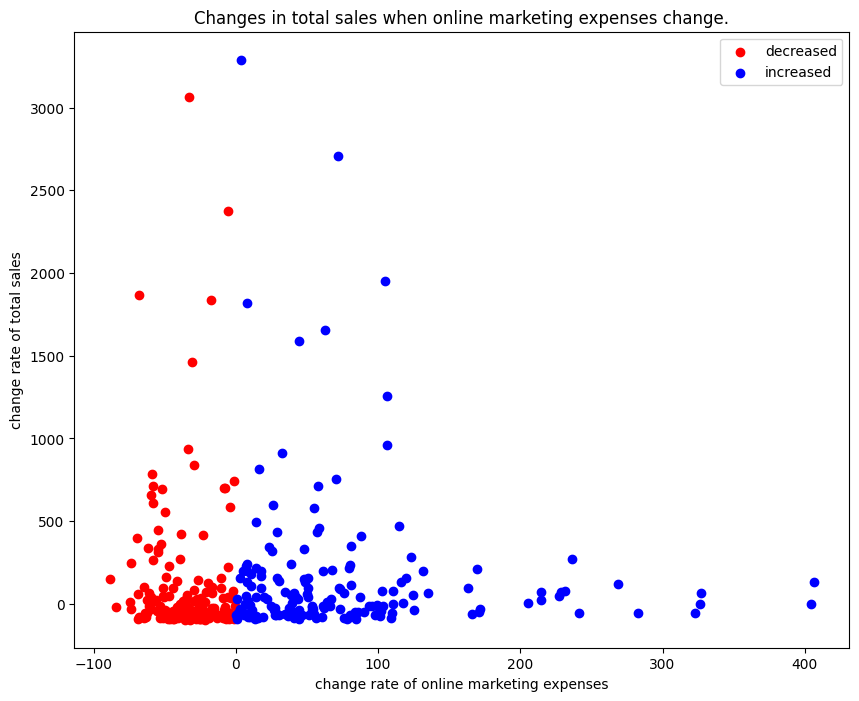

In [185]:
decreased_cost = pd.DataFrame()
increased_cost = pd.DataFrame()

'''
이제 classified_bills 안에 있는 각 데이터프레임을 순회하며
비용증감이 음수면 decreased_cost에,
비용증감이 양수면 increased_cost에 데이터를 삽입합니다.

이렇게 만들어진 두 개의 데이터프레임을 바탕으로 산점도를 그려
온라인 비용의 증감이 매출 증감에 어떤 영향을 미치는지 살펴보도록 하겠습니다.
'''

for df in classified_bills:
    decreased_cost = pd.concat([decreased_cost, df[df['비용증감'] < 0]])
    increased_cost = pd.concat([increased_cost, df[df['비용증감'] > 0]])

plt.figure(figsize=(10, 8))
# 비용증감이 음수인 경우 빨간색으로 표시
plt.scatter(decreased_cost['비용증감'], decreased_cost['매출증감'], color='red', label='decreased')
plt.scatter(increased_cost['비용증감'], increased_cost['매출증감'], color='blue', label='increased')

plt.title('Changes in total sales when online marketing expenses change.')
plt.xlabel('change rate of online marketing expenses')
plt.ylabel('change rate of total sales')
plt.legend()
plt.show()

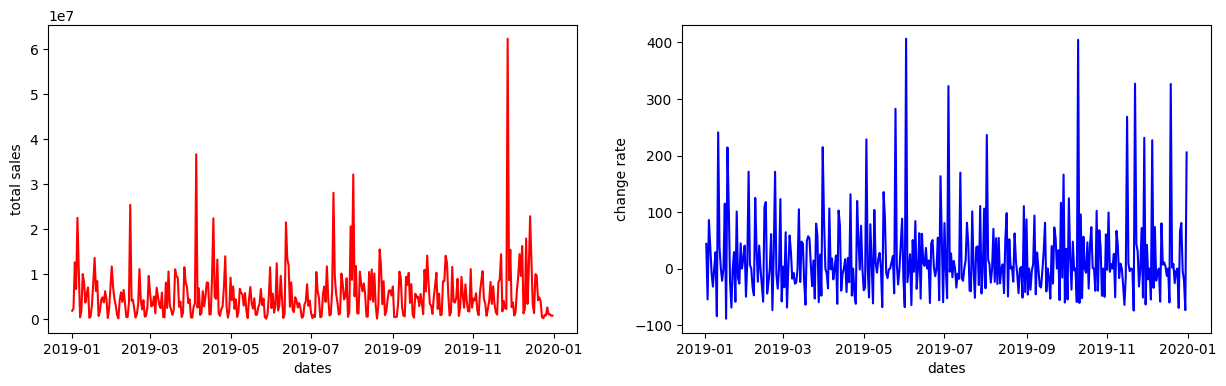

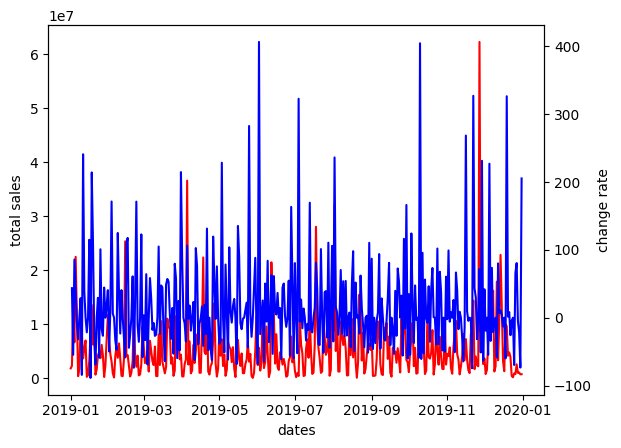

In [186]:
tmp_data = pd.DataFrame()

for df in classified_bills:
    tmp_data = pd.concat([tmp_data, df])

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(tmp_data['날짜'], tmp_data['총매출액'], color='red', label='change of total sales')
plt.xlabel('dates')
plt.ylabel('total sales')

plt.subplot(1, 2, 2)
plt.plot(tmp_data['날짜'], tmp_data['비용증감'], color='blue', label='change rate of costs')
plt.xlabel('dates')
plt.ylabel('change rate')

fig, ax1 = plt.subplots()
ax1.plot(tmp_data['날짜'], tmp_data['총매출액'], color='red', label='change of total sales')
ax1.set_xlabel('dates')
ax1.set_ylabel('total sales')

ax2 = ax1.twinx()
ax2.plot(tmp_data['날짜'], tmp_data['비용증감'], color='blue', label='change rate of costs')
ax2.set_ylabel('change rate')

plt.show()

## 분석
---

산점도로 보나, 그래프로 보나 마케팅비용과 매출액은 큰 연관성이 없어보입니다.

양의 상관관계도, 음의 상관관계도 없다는 결론을 내릴 수 있습니다.

온라인 비용이 들쭉날쭉하다는 것은

CPM이나 CPC와 같은 온라인 마케팅 비용을 효율화하기 위해

퍼포먼스 마케팅을 진행하고 있다는 것으로 유추할 수 있는데,

이러한 과정이 명시적인 성과를 내고있진 못한 것 같습니다.

추가적으로, 마케팅 비용과는 별개로 시간이 지남에 따라 매출액이 우상향하지 않는 모습을 보입니다.

즉, **해당 이커머스 플랫폼 자체의 성장이 이루어지지 않고있다는 분석**이 가능합니다.

## 발전
---

퍼포먼스 마케팅 뿐만아니라 할인쿠폰을 더 적극적으로 제공하는 등

다양한 방법을 통해 유입된 유저들의 리텐션을 유지하는 것이 중요합니다.

이에 더해 다양한 고객의 필요를 충족시킬 수 있도록 상품의 다양화를 진행하거나

기존 유저의 매출을 증대시킬 수 있도록 추천 알고리즘의 개선이 필요해보입니다.

# [3. 간단한 고객 분석]

## 3-1. 가입 기간과 매출액의 관계
---

가입 기간이 오래된 고객에게 프로모션을 진행하는 아이디어를 생각해볼 수 있습니다.

가입 기간이 오래될수록 매출액은 늘어날까요? 한번 알아보겠습니다.

### 분석 방법
---
단순히 각 유저의 총 매출액을 기준으로 한다면,

리텐션이 일정하다는 가정 하에 가입 기간이 길수록 매출액이 당연히 높을 수밖에 없습니다.

따라서 제공된 데이터가 1년치의 데이터이므로

4분기에 해당하는 10월, 11월, 12월에 제품을 구매한 유저의 총 매출액을 구한 다음

각 유저의 가입기간과 매출액의 크기를 살펴보도록 하겠습니다.

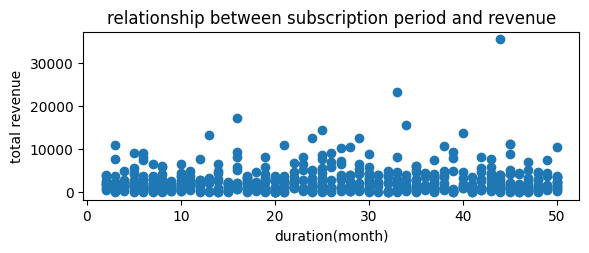

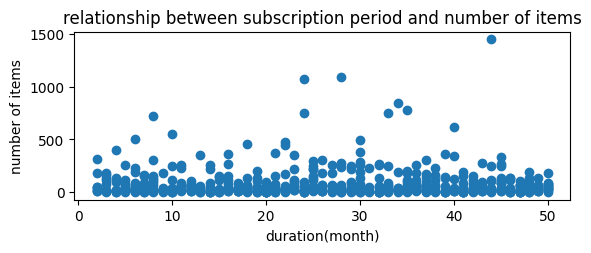

In [193]:
# 날짜가 10월 1일 이후인 데이터만 추출,
# 유저별로 총 매출액 합산하여 별도의 dataframe에 삽입
date = datetime(2019, 10, 1)
tmp = onlinesales[onlinesales['거래날짜'] >= date].copy()
tmp['총매출'] = tmp['수량'] * tmp['평균금액']

grouped = tmp.groupby('고객ID').agg({'수량':'sum', '총매출':'sum'}).reset_index()

# 고객ID를 기준으로 grouped데이터와 customer데이터를 병합
merged = pd.merge(customer[['고객ID', '가입기간']], grouped, on='고객ID')

plt.subplot(2, 1, 1)
plt.scatter(merged['가입기간'], merged['총매출'])
plt.xlabel('duration(month)')
plt.ylabel('total revenue')
plt.title('relationship between subscription period and revenue')
plt.show()

plt.subplot(2, 1, 2)
plt.scatter(merged['가입기간'], merged['수량'])
plt.xlabel('duration(month)')
plt.ylabel('number of items')
plt.title('relationship between subscription period and number of items')
plt.show()

## 결과
---
> **4분기(10월, 11월, 12월)에 물건을 구매한 유저 중 가입기간과 매출액에 상관관계가 있다는 가설은 기각되었습니다.**
>
> **가입 기간과 구매 개수에 상관관계가 있다는 가설도 기각되었습니다.**

따라서 가입기간이 오래되었다고 할인 쿠폰을 제공하는 행사나,

신규 가입이라고 할인 쿠폰을 제공하는 등의 행사를 진행하고자 할 때

현재로선 가입 기간에 따른 매출액 추이에 연관성이 없기때문에

해당 행사의 진행 여부를 조금 더 면밀히 검토해야 할 필요가 있습니다.

## 3-2. 각 카테고리의 충성 고객; 지역과 성별로 살펴보기
---
지역에 따라, 혹은 성별에 따라 자주 구매하는 물건의 카테고리가 나뉘어져 있을까요? 한번 살펴보겠습니다.

In [189]:
grouped = onlinesales.groupby(['고객ID', '제품카테고리']).agg({'수량':'sum', '평균금액':'sum'}).reset_index()

merged = pd.merge(customer[['고객ID', '성별', '고객지역']], grouped, on='고객ID')

filtered_by_sex = merged.groupby('제품카테고리').agg(
    남자=('성별', lambda x: np.sum(x == '남')),
    여자=('성별', lambda x: np.sum(x == '여')),
    남자총수량=('수량', lambda x: np.sum(x[merged['성별'] == '남'])),
    여자총수량=('수량', lambda x: np.sum(x[merged['성별'] == '여']))
    ).reset_index()
filtered_by_sex

,제품카테고리,남자,여자,남자총수량,여자총수량
0,Accessories,55,95,319,778
1,Android,16,26,18,27
2,Apparel,486,837,11636,20802
3,Backpacks,39,36,49,64
4,Bags,277,451,4376,10897
5,Bottles,74,129,1030,1060
6,Drinkware,341,578,11307,19194
7,Fun,49,69,432,402
8,Gift Cards,30,47,57,149
9,Google,35,54,148,427


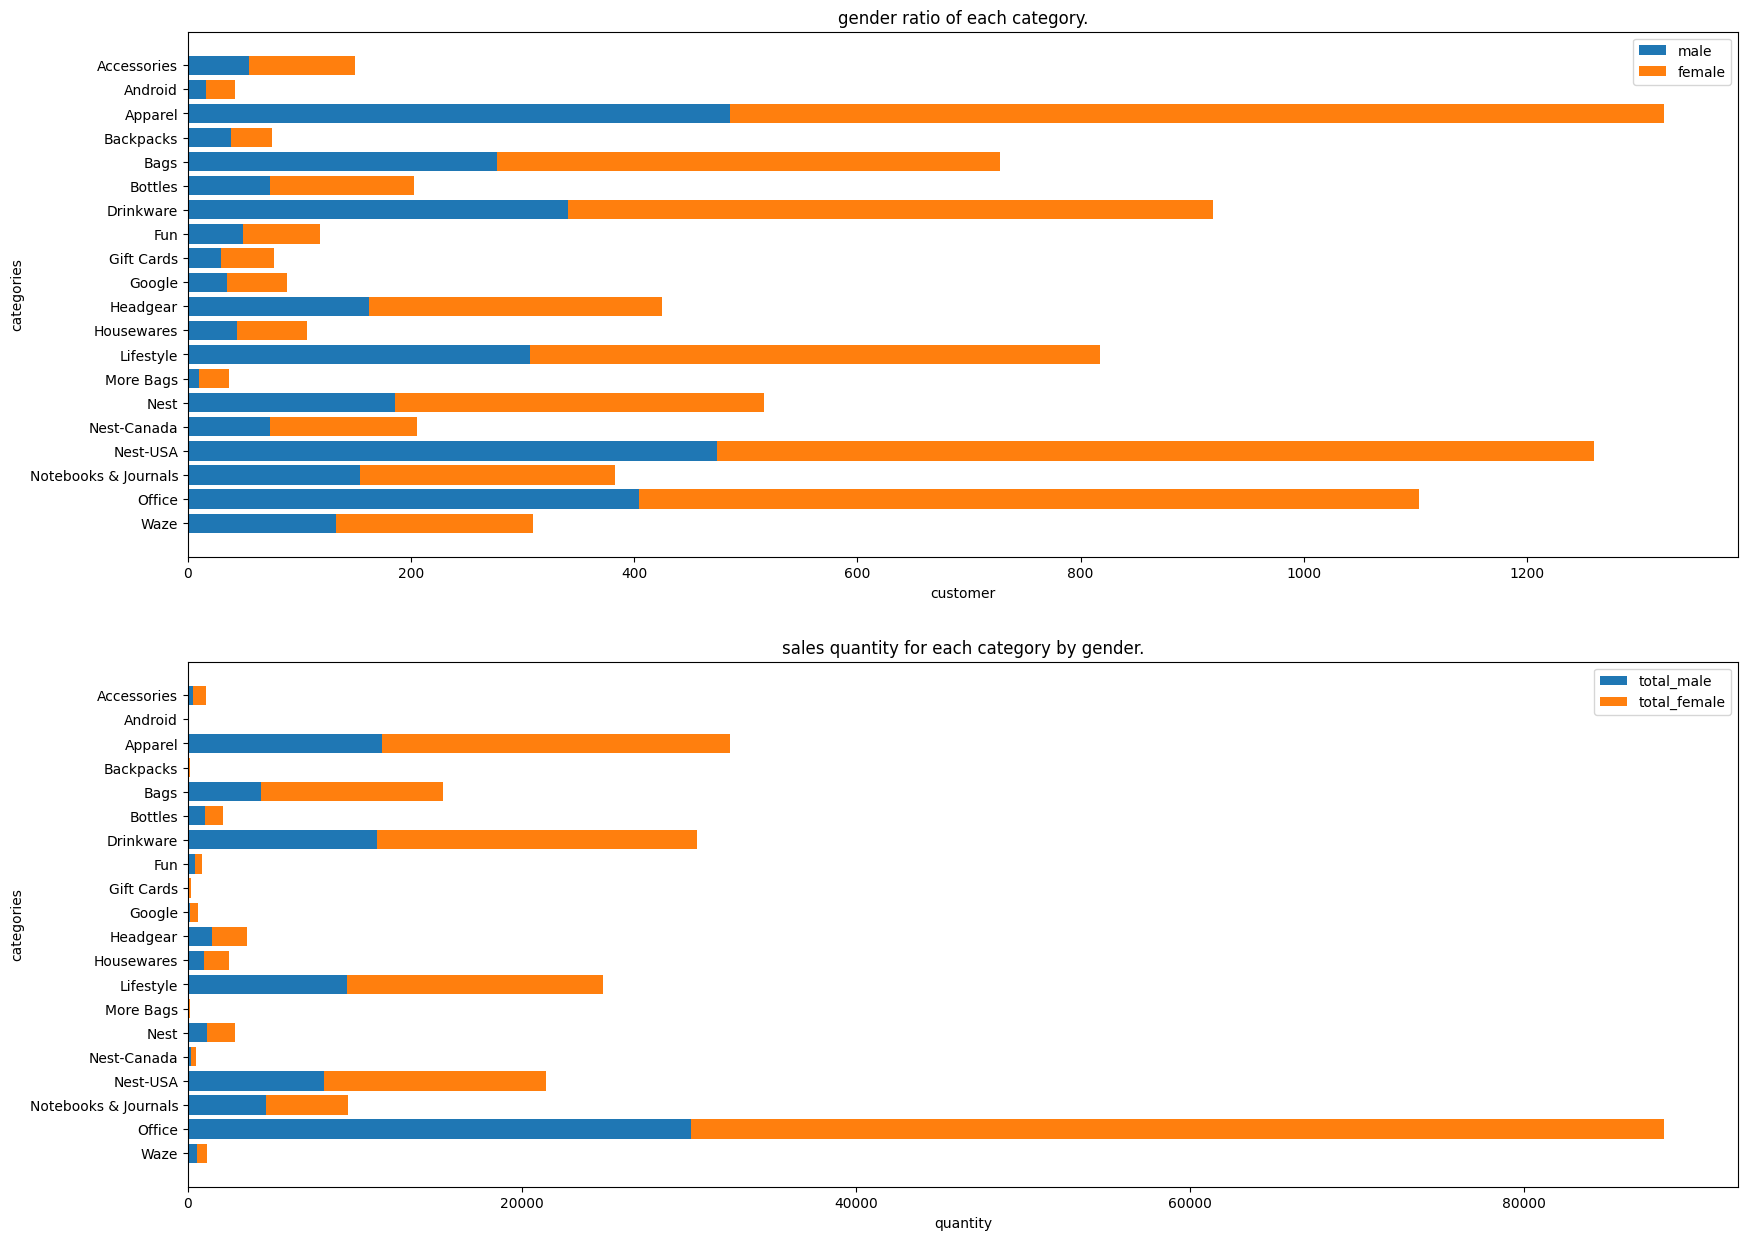

In [190]:
# 그래프를 그리기 위한 데이터 추출
categories = filtered_by_sex['제품카테고리']
male = filtered_by_sex['남자']
female = filtered_by_sex['여자']
total_male = filtered_by_sex['남자총수량']
total_female = filtered_by_sex['여자총수량']

plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.barh(categories, male, label='male')
plt.barh(categories, female, left=male, label='female')
plt.xlabel('customer')
plt.ylabel('categories')
plt.title('gender ratio of each category.')
plt.legend()
plt.gca().invert_yaxis()

plt.subplot(2, 1, 2)
plt.barh(categories, total_male, label='total_male')
plt.barh(categories, total_female, left=total_male, label='total_female')
plt.xlabel('quantity')
plt.ylabel('categories')
plt.title('sales quantity for each category by gender.')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

## 결과
---

모든 카테고리에서, 남성보다 여성이 구매한 횟수가 많았으며

총 구매수량 또한 여성이 더욱 많다는 것을 알 수 있습니다.

따라서 마케팅이나 행사를 진행할 계획이라면 여성을 겨냥하여 계획하는 것이 합리적으로 보입니다.

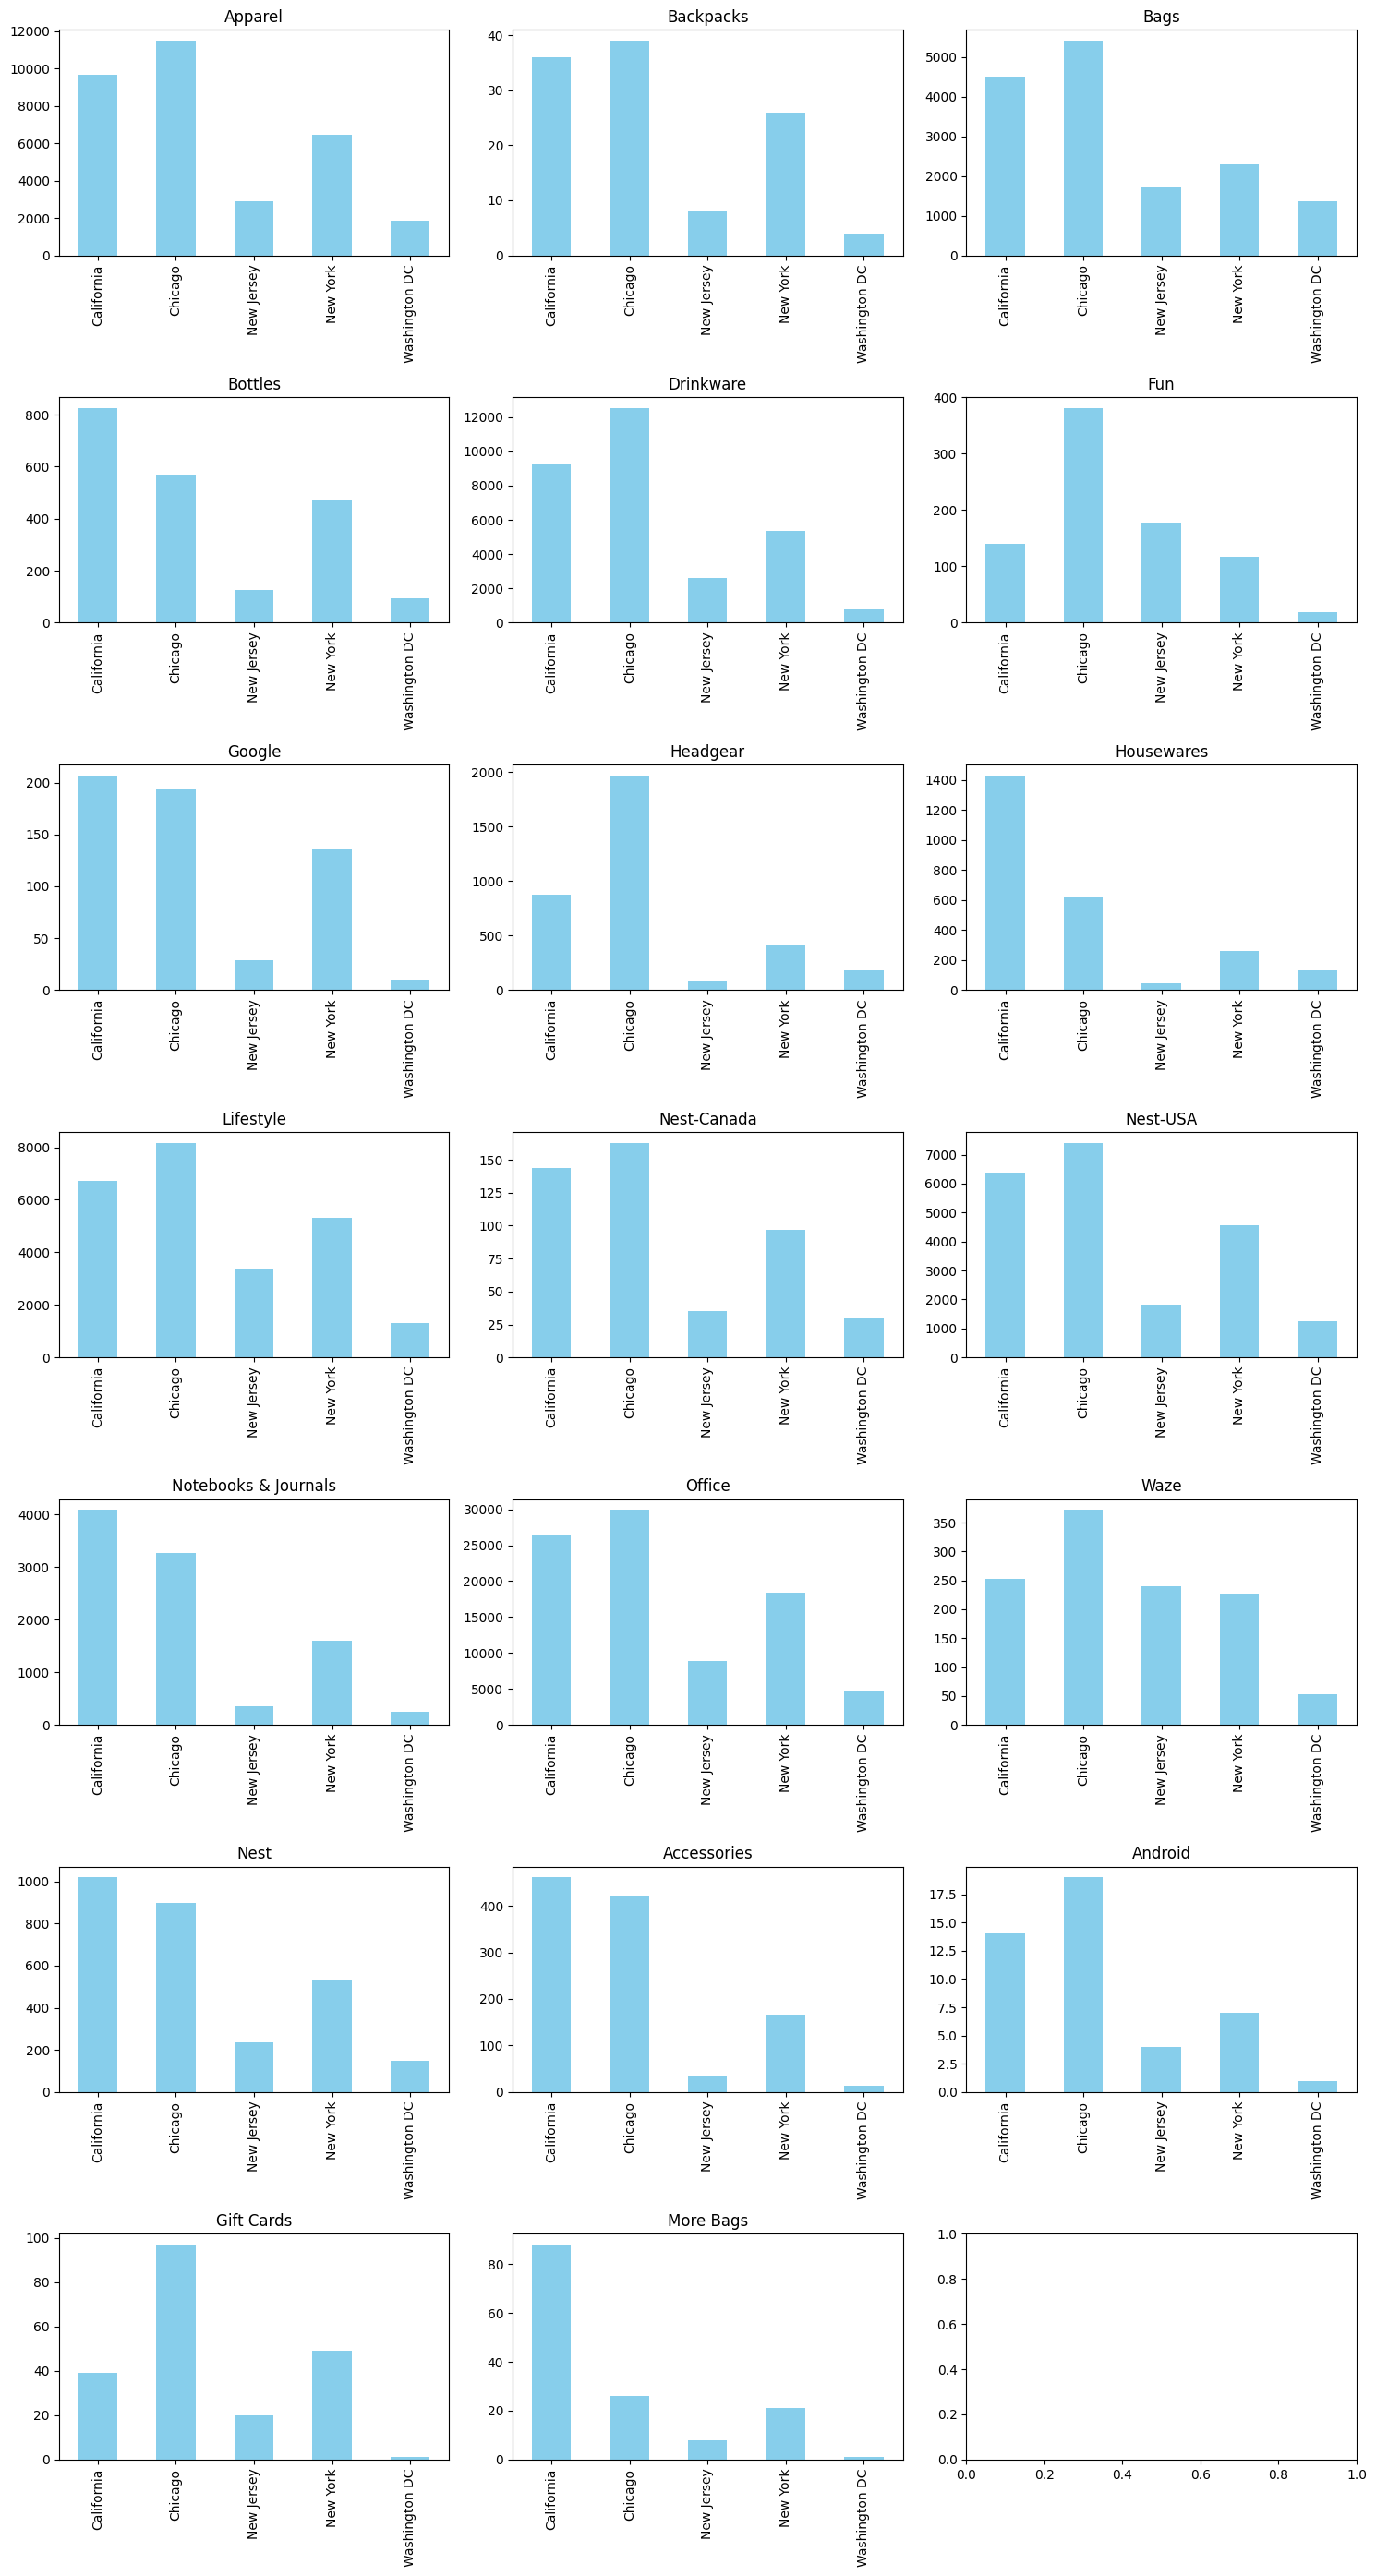

In [191]:
categories = merged['제품카테고리'].unique()

num_cols = 3 
num_rows = int(np.ceil(len(categories) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows))

for i, category in enumerate(categories):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    data = merged[merged['제품카테고리'] == category].groupby('고객지역')['수량'].sum()
    data.plot(kind='bar', ax=ax, color='skyblue')
    
    ax.set_title(f'{category}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

## 결과
---
> Fun 카테고리를 제외하고, 나머지 모든 카테고리에서 California와 Chicago 지역이 매출량 1위와 2위를 다투고 있습니다.

즉, 지역을 중심으로 리텐션을 강화하기 위해서 California와 Chicago에 서비스를 강화하는 전략을 구사할수도 있고,

새로운 유입을 발생시키기 위해 New Jersey, New York, Washington DC에 서비스를 강화하는 전략을 구사할수도 있습니다.

New Jersey와 New York의 경우 카테고리에 따라 California, Chicago와 비슷한 매출량을 달성하는 경우가 있으니 조금의 마케팅과 투자가 이루어진다면

California, Chicago와 비슷한 수준의 매출량을 달성할 가능성이 있습니다.

그러나 Washington DC의 경우 거의 모든 카테고리에서 저조한 판매량을 기록하고 있으므로 Washington DC 지역의 투자에 대해서는 재고할 필요가 있습니다.

# [4. 세금, 그리고 매출]
---

각 카테고리에는 세금이 붙습니다. 그렇다면 세금이 높을수록 매출량은 줄어들까요?

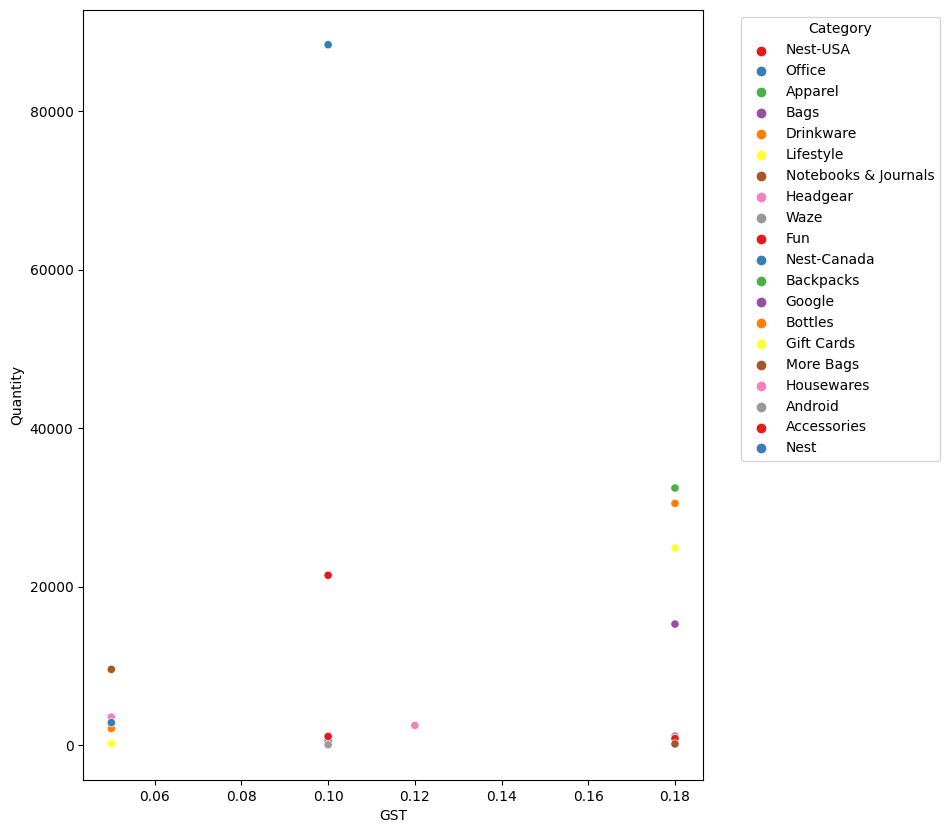

In [209]:
grouped = onlinesales.groupby('제품카테고리').agg({'수량':'sum'}).reset_index()

merged = pd.merge(tax, grouped, on='제품카테고리')

# 산점도 그리기
plt.figure(figsize=(8, 10))
sns.scatterplot(data=merged, x='GST', y='수량', hue='제품카테고리', palette='Set1')
plt.title('')
plt.xlabel('GST')
plt.ylabel('Quantity')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 결과
---
세금과 매출량 사이에는 상관관계가 없는 것으로 보입니다.

정책의 변화로 인해 세금이 증가했을 때 매출량의 감소를 걱정할 필요는 없다는 것을 의미하기도 합니다.

# [5. 할인율과 매출의 주기성]
---
`discount.csv` 파일을 살펴보면, 총 17개의 카테고리가 3개월을 주기로 각각 10%, 20%, 30%의 할인 주기를 갖는 것을 발견할 수 있습니다.

In [214]:
# 예시로 Office 카테고리만 보도록 하겠습니다.
filtered_disc = discount[discount['제품카테고리'] == 'Office']
filtered_disc

,월,제품카테고리,쿠폰코드,할인율
6,Jan,Office,OFF10,10
7,Feb,Office,OFF20,20
8,Mar,Office,OFF30,30
57,Apr,Office,OFF10,10
58,May,Office,OFF20,20
59,Jun,Office,OFF30,30
108,Jul,Office,OFF10,10
109,Aug,Office,OFF20,20
110,Sep,Office,OFF30,30
159,Oct,Office,OFF10,10


> 사람들은 보통 할인율과 매출량은 양의 상관관계를 갖는다고 합니다.

이 데이터에서도 그러한 경향을 발견할 수 있을까요? 가설이 맞다면,

할인 주기를 갖는 카테고리는 매출 또한 주기성을 가져야합니다.

이를 알아봄으로서 각 월마다 다른 할인율을 제공하는 것이 매출 증대에 도움이 되는지 살펴보도록 하겠습니다.

In [228]:
# 데이터 형식을 onlinesales 데이터와 맞춰주도록 하겠습니다
discount_copy = discount.copy()
discount_copy['월'] = discount_copy['월'].replace({
    'Jan': '1',
    'Feb': '2',
    'Mar': '3',
    'Apr': '4',
    'May': '5',
    'Jun': '6',
    'Jul': '7',
    'Aug': '8',
    'Sep': '9',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
})

coupon_used = onlinesales[onlinesales['쿠폰상태'] == 'Used'].copy()
coupon_used['월'] = coupon_used['거래날짜'].dt.month
coupon_used['총매출액'] = coupon_used['수량'] * coupon_used['평균금액']

grouped = coupon_used.groupby(['월', '제품카테고리']).agg({'수량':'sum', '총매출액':'sum'}).reset_index()
grouped

,월,제품카테고리,수량,총매출액
0,1,Android,2,41.24
1,1,Apparel,519,12937.75
2,1,Bags,296,2318.38
3,1,Bottles,32,117.53
4,1,Drinkware,710,4193.16
...,...,...,...,...
196,12,Nest-Canada,12,1924.48
197,12,Nest-USA,739,91678.30
198,12,Notebooks & Journals,40,717.20
199,12,Office,1911,8120.06


# 결론 요약

---

## 